# PLAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
from scipy.signal import find_peaks
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import GridSearchCV, train_test_split as split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve

### Loading data

In [2]:
train = pd.read_parquet('../data/train.parquet')
test = pd.read_parquet('../data/test.parquet')
sample_submission = pd.read_csv('../data/sample_submission.csv')

### Show data

In [3]:
train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [4]:
test.head()

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   dates   20000 non-null  object
 2   values  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


### Distribution of classes

In [7]:
#Checking dataframe's shape
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (80000, 4)
test shape: (20000, 3)


In [8]:
unique_values = train['label'].unique()
print(unique_values)

[0. 1.]


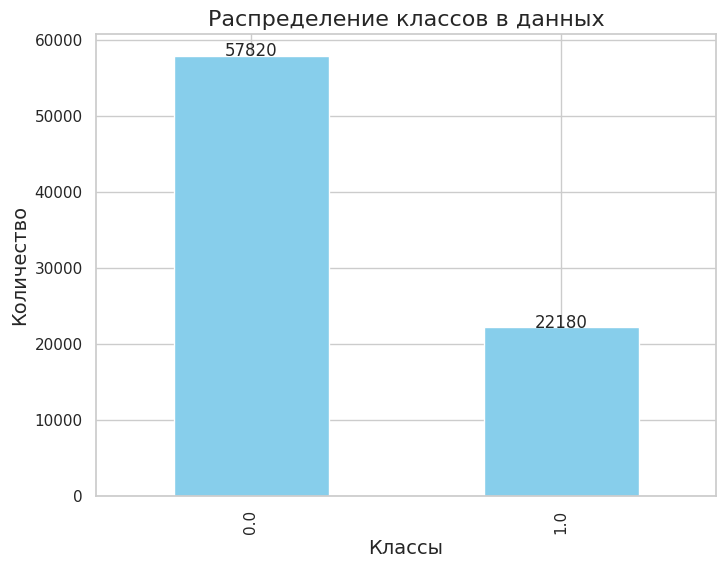

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

train['label'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Распределение классов в данных', fontsize=16)
plt.xlabel('Классы', fontsize=14)
plt.ylabel('Количество', fontsize=14)

for i, value in enumerate(train['label'].value_counts()):
    plt.text(i, value + 5, str(value), ha='center', fontsize=12)

plt.show()

In [11]:
class_counts = train['label'].value_counts(normalize=True) * 100
print(class_counts)

label
0.0    72.275
1.0    27.725
Name: proportion, dtype: float64


##### Convert data into dataframe

In [12]:
def conv_into_df(data):
    data = pd.DataFrame(data)
    return data

In [13]:
train_df = conv_into_df(train)
test_df = conv_into_df(test)

In [14]:
train_df.dtypes

id          int64
dates      object
values     object
label     float64
dtype: object

In [15]:
print(type(train_df['values'][0][0]))
print(type(train_df['dates'][0][0]))

<class 'numpy.float64'>
<class 'datetime.date'>


##### Missing values

In [20]:
def check_missing_in_lists(row):
    return any(pd.isnull(item) for sublist in row if isinstance(sublist, list) for item in sublist)

In [16]:
def fillna_in_lists(column):
    def fill_list(lst):
        if isinstance(lst, list):
            clean_lst = [x for x in lst if pd.notnull(x)]  
            if len(clean_lst) > 0:
                median_value = np.median(clean_lst)  
                return [x if pd.notnull(x) else median_value for x in lst]  
            else:
                return [0]*len(lst) 
        return lst  
    return column.apply(fill_list)

In [17]:
train_df['values'] = fillna_in_lists(train_df['values'])
train_df

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [18]:
test_df['values'] = fillna_in_lists(test_df['values'])
test_df

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."
...,...,...,...
19995,80341,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[3.01, -0.58, 1.55, 0.48, -0.35, 1.93, 3.86, 2..."
19996,5891,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[0.66, 1.3, 2.78, -0.25, -1.97, -0.55, -1.08, ..."
19997,29091,"[2017-01-01, 2017-02-01, 2017-03-01, 2017-04-0...","[0.09, 0.44, 1.55, 0.15, 0.3, 0.19, 0.34, 1.05..."
19998,85877,"[2017-04-01, 2017-05-01, 2017-06-01, 2017-07-0...","[0.28, 1.92, 1.14, 2.4, 1.46, 1.08, -0.12, 0.6..."


In [26]:
train_df['dates_miss'] = train_df['dates'].apply(lambda x: any(pd.isnull(x)))
print(train_df['dates_miss'].unique())

[False]


In [46]:
train_df.drop(columns=['dates_miss'], axis=1)
train_df

,id,dates,values,label,dates_miss,autocorr_sign
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,False,0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,False,0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,False,1
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,False,1
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,False,0
...,...,...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0,False,0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0,False,1
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0,False,1
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0,False,1


In [27]:
test_df['dates_miss'] = test_df['dates'].apply(lambda x: any(pd.isnull(x)))
print(test_df['dates_miss'].unique())

[False]


### 1. Statistical Features

In [37]:
def generate_stat_features(data):
    stat_features = {}

    stat_features['mean'] = data['values'].apply(np.mean)
    stat_features['std_value'] = data['values'].apply(np.std)
    stat_features['min_value'] = data['values'].apply(np.min)
    stat_features['max_value'] = data['values'].apply(np.max)
    stat_features['median_value'] = data['values'].apply(np.median)
    stat_features['q1_value'] = data['values'].apply(lambda x: np.percentile(x, 25))
    stat_features['q3_value'] = data['values'].apply(lambda x: np.percentile(x, 75))
    stat_features['skewness_value'] = data['values'].apply(skew)
    stat_features['kurtosis_value'] = data['values'].apply(kurtosis)
    stat_features['peaks_value'] = data['values'].apply(lambda x: len(find_peaks(x)[0]))
    
    stat_features_df = pd.DataFrame(stat_features)
    
    return stat_features_df

In [38]:
train_stat = generate_stat_features(train_df)

In [39]:
test_stat = generate_stat_features(test_df)

In [40]:
train_stat.head()

,mean,std_value,min_value,max_value,median_value,q1_value,q3_value,skewness_value,kurtosis_value,peaks_value
0,0.023710,1.337272,-4.840000,3.49,-0.110000,-0.6825,0.7700,-0.304166,1.889654,19
1,-0.310777,1.556337,-3.534409,2.92,-0.274409,-1.0400,0.7100,-0.011952,-0.107257,14
2,-0.046042,1.065023,-1.950000,2.61,-0.145000,-0.8775,0.6150,0.377148,-0.272738,15
3,-0.130000,1.158201,-2.220000,2.49,-0.345000,-0.9500,0.8250,0.112395,-0.849629,11
4,-0.270536,1.270529,-2.500000,2.87,-0.475000,-1.2500,0.6775,0.398655,-0.587199,17


### 2. Time-Domain Features (Autocorrelation)

In [47]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def detect_autocorrelation(data, lag=1, threshold=0.5):
    """
    1 - положительная автокорреляция выше порога,
    0 - автокорреляции нет,
    -1 - отрицательная автокорреляция ниже порога.
    """
    data_copy = data.copy()
    
    def autocorr_classification(x, lag, threshold):
        x_array = np.array(x)
        
        if np.std(x_array) == 0:
            return 0  
        else:
            autocorr_value = pd.Series(x_array).autocorr(lag=lag)
            if autocorr_value > threshold:
                return 1 
            elif autocorr_value < -threshold:
                return -1  
            else:
                return 0  

    data_copy['autocorr_sign'] = data_copy['values'].apply(lambda x: autocorr_classification(x, lag, threshold))
    
    return data_copy

In [48]:
autocorr = detect_autocorrelation(train_df, lag=1, threshold=0.3)
autocorr

,id,dates,values,label,dates_miss,autocorr_sign
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,False,0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,False,0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,False,1
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,False,1
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,False,0
...,...,...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0,False,0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0,False,1
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0,False,1
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0,False,1


In [58]:
merged_train_df = train_stat.join(autocorr[['autocorr_sign', 'label']])

In [59]:
merged_train_df.head()

,mean,std_value,min_value,max_value,median_value,q1_value,q3_value,skewness_value,kurtosis_value,peaks_value,autocorr_sign,label
0,0.023710,1.337272,-4.840000,3.49,-0.110000,-0.6825,0.7700,-0.304166,1.889654,19,0,0.0
1,-0.310777,1.556337,-3.534409,2.92,-0.274409,-1.0400,0.7100,-0.011952,-0.107257,14,0,1.0
2,-0.046042,1.065023,-1.950000,2.61,-0.145000,-0.8775,0.6150,0.377148,-0.272738,15,1,0.0
3,-0.130000,1.158201,-2.220000,2.49,-0.345000,-0.9500,0.8250,0.112395,-0.849629,11,1,0.0
4,-0.270536,1.270529,-2.500000,2.87,-0.475000,-1.2500,0.6775,0.398655,-0.587199,17,0,0.0


In [60]:
print(merged_train_df['autocorr_sign'].unique())

[ 0  1 -1]


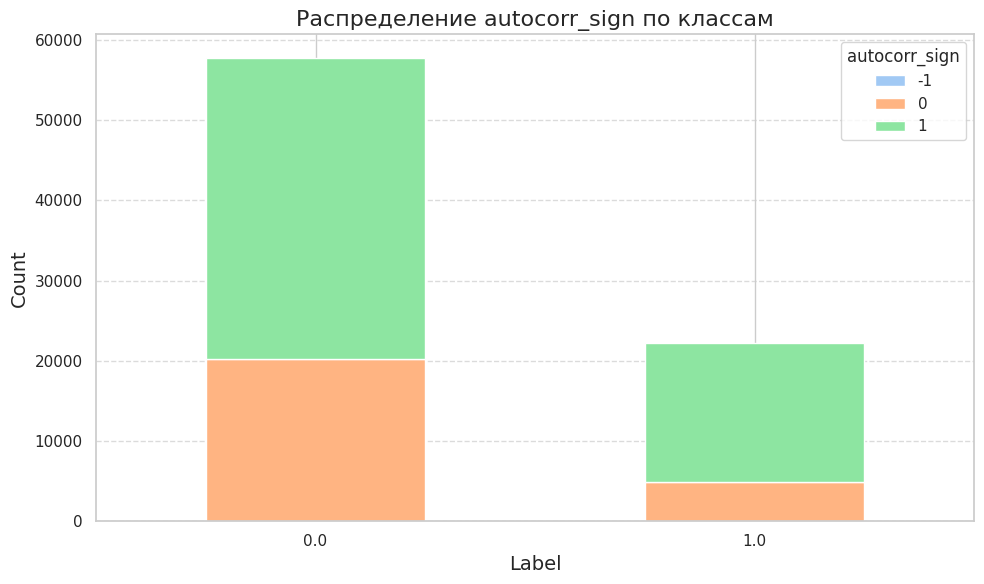

In [62]:
sns.set(style="whitegrid")
ax = class_autocorr_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=sns.color_palette("pastel"))

plt.title('Распределение autocorr_sign по классам', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0) 
plt.legend(title='autocorr_sign', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()

In [63]:
merged_train_df['autocorr_sign'] = merged_train_df['autocorr_sign'].replace(-1, 0)

### 3. Frequency-Domain Features

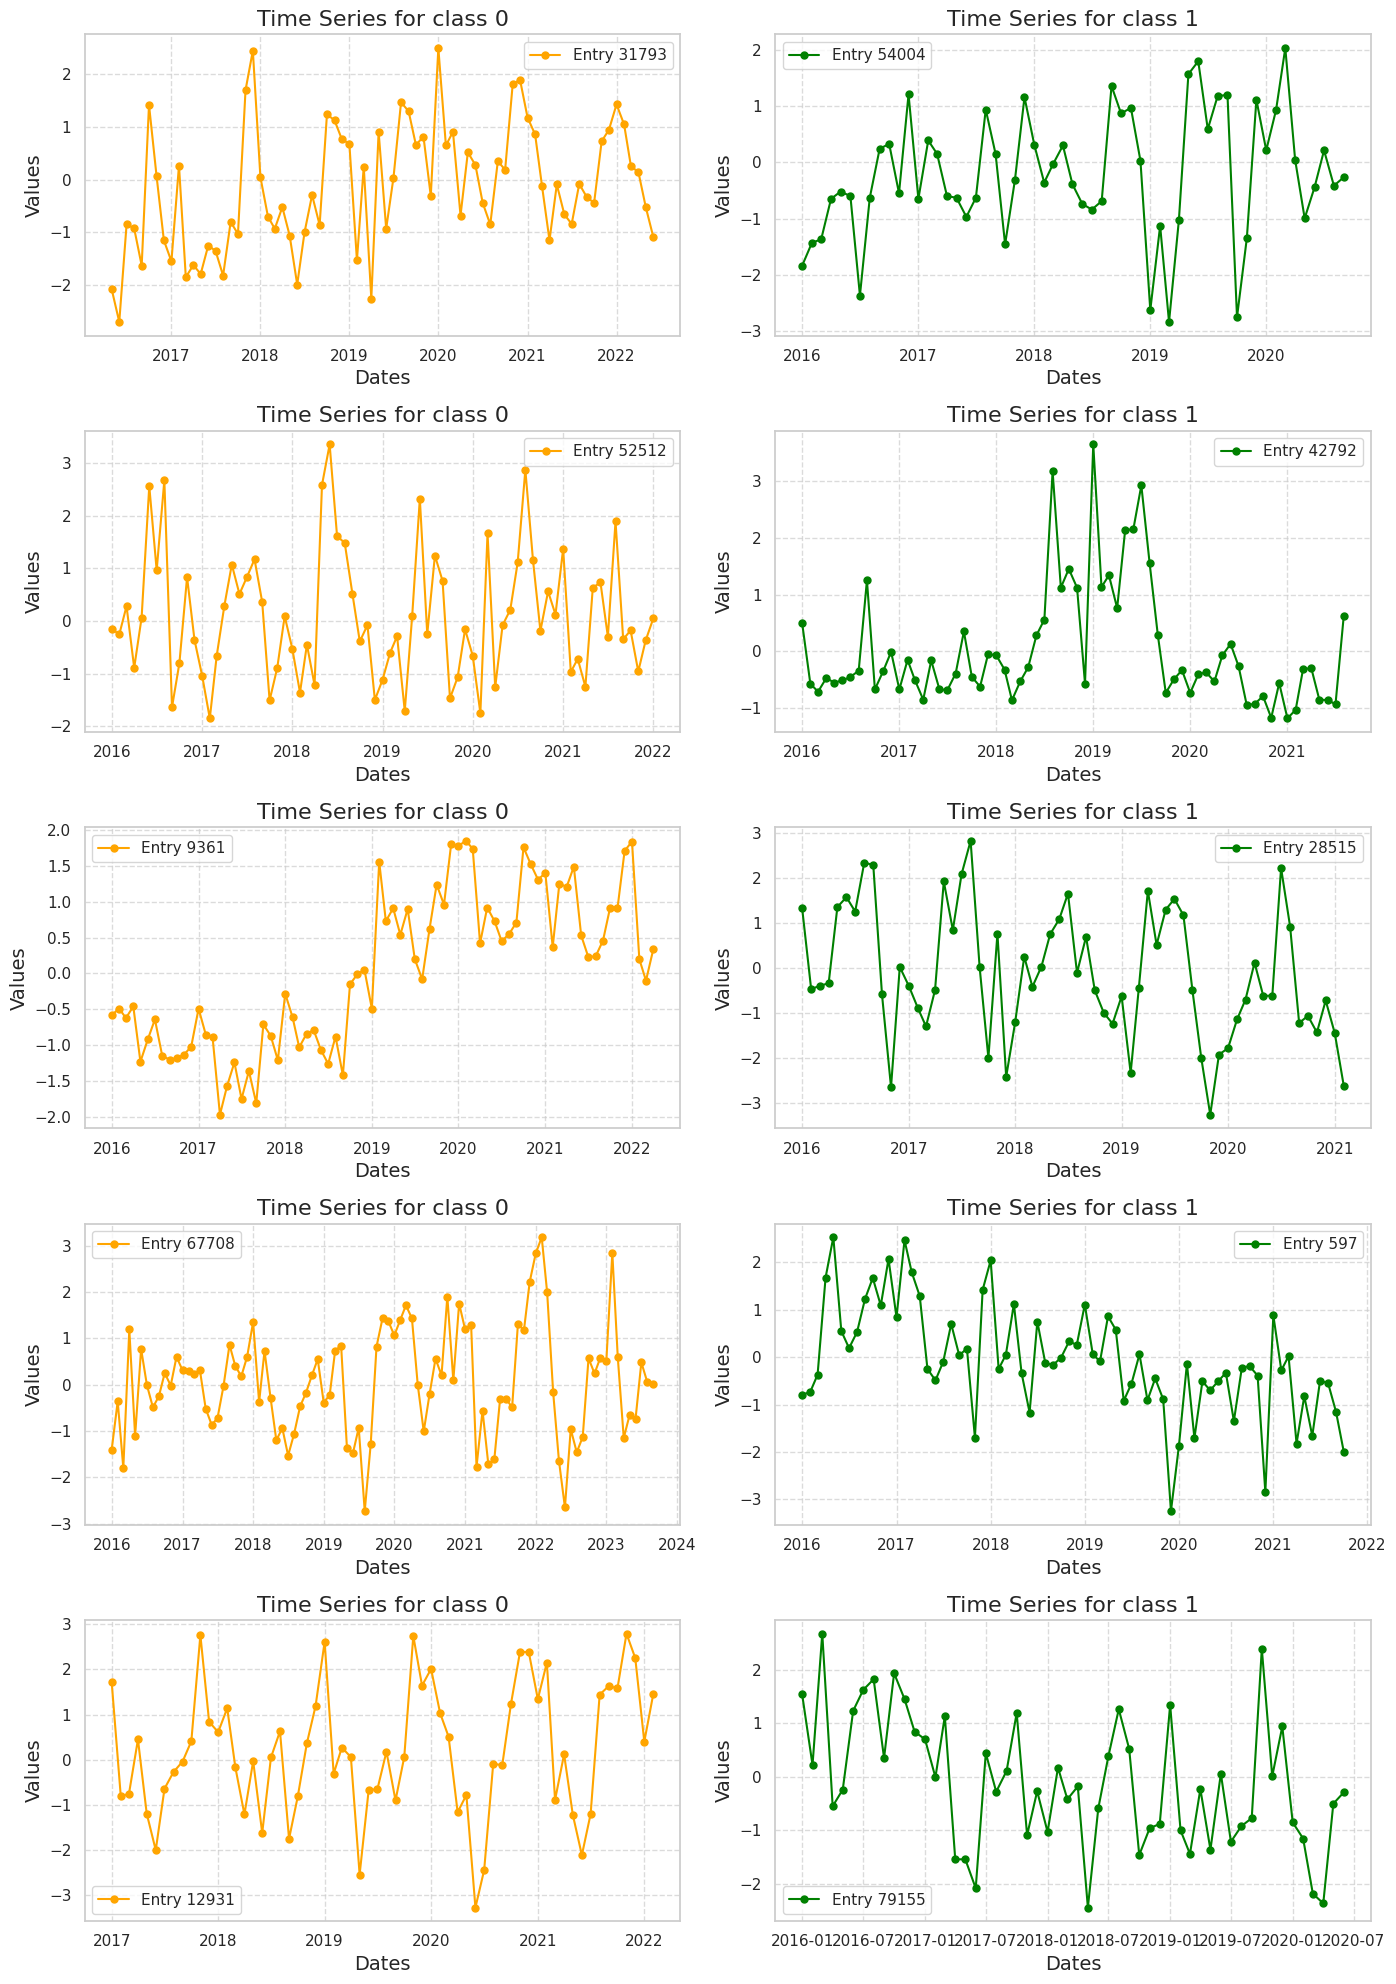

In [72]:
class_1_subset = train_df[train_df['label'] == 1].sample(n=5, random_state=1)  
class_0_subset = train_df[train_df['label'] == 0].sample(n=5, random_state=1)  

def plot_time_series_for_class(subset, class_label, color, ax):
    for index, row in subset.iterrows():
        ax.plot(row['dates'], row['values'], marker='o', markersize=5, color=color, label=f'Entry {index}')  

    ax.set_title(f'Time Series for class {class_label}', fontsize=16)
    ax.set_xlabel('Dates', fontsize=14)
    ax.set_ylabel('Values', fontsize=14)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

sns.set(style="whitegrid")

fig, axs = plt.subplots(5, 2, figsize=(14, 20))

for i, ax in enumerate(axs[:, 0]):
    if i < len(class_0_subset):  
        plot_time_series_for_class(class_0_subset.iloc[[i]], 0, color='orange', ax=ax)


for i, ax in enumerate(axs[:, 1]):
    if i < len(class_1_subset):  
        plot_time_series_for_class(class_1_subset.iloc[[i]], 1, color='green', ax=ax)

plt.tight_layout()
plt.show()

In [29]:
def extract_features(data):
    def calculate_amplitude(group):
        time_series = group['values'].values
        fft_values = np.fft.rfft(time_series)
        amplitude = np.abs(fft_values) // 2
        
        group['mean_amplitude'] = np.mean(amplitude)
        return group
    
    data_with_amplitude = data.groupby('id').apply(calculate_amplitude)
    
    return data_with_amplitude

In [31]:
train_stat_corr_ampl = extract_features(train_stat_corr)

/tmp/ipykernel_89190/1804637180.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_with_amplitude = data.groupby('id').apply(calculate_amplitude)


In [33]:
train_stat_corr_ampl

id      dates    values  label  mean_value  std_value  \
id                                                                        
0     0            0 2016-01-01  1.740000    0.0   -0.024030   1.040184   
      1            0 2016-02-01  2.970000    0.0   -0.024030   1.040184   
      2            0 2016-03-01  0.440000    0.0   -0.024030   1.040184   
      3            0 2016-04-01  1.060000    0.0   -0.024030   1.040184   
      4            0 2016-05-01 -1.130000    0.0   -0.024030   1.040184   
...              ...        ...       ...    ...         ...        ...   
99999 5155407  99999 2020-07-01 -2.250483    1.0   -0.179921   1.528277   
      5155408  99999 2020-08-01 -2.140483    1.0   -0.179921   1.528277   
      5155409  99999 2020-09-01 -1.280483    1.0   -0.179921   1.528277   
      5155410  99999 2020-10-01 -3.130483    1.0   -0.179921   1.528277   
      5155411  99999 2020-11-01 -1.550483    1.0   -0.179921   1.528277   

               min_value  max_value  median_value  q1_value  q3_value  \
id                                                                      
0     0        -1.630000       5.57         -0.16 -0.540000     0.145   
      1        -1.630000       5.57         -0.16 -0.540000     0.145   
      2        -1.630000       5.57         -0.16 -0.540000     0.145   
      3        -1.630000       5.57         -0.16 -0.540000     0.145   
      4        -1.630000       5.57         -0.16 -0.540000     0.145   
...                  ...        ...           ...       ...       ...   
99999 5155407  -3.130483       2.53         -0.33 -1.295242     1.155   
      5155408  -3.130483       2.53         -0.33 -1.295242     1.155   
      5155409  -3.130483       2.53         -0.33 -1.295242     1.155   
      5155410  -3.130483       2.53         -0.33 -1.295242     1.155   
      5155411  -3.130483       2.53         -0.33 -1.295242     1.155   

               skewness_value  kurtosis_value  autocorr_sign  mean_amplitude  
id                                                                            
0     0              2.789770       11.574777              0        3.235294  
      1              2.789770       11.574777              0        3.235294  
      2              2.789770       11.574777              0        3.235294  
      3              2.789770       11.574777              0        3.235294  
      4              2.789770       11.574777              0        3.235294  
...                       ...             ...            ...             ...  
99999 5155407        0.027795       -1.055300              1        4.266667  
      5155408        0.027795       -1.055300              1        4.266667  
      5155409        0.027795       -1.055300              1        4.266667  
      5155410        0.027795       -1.055300              1        4.266667  
      5155411        0.027795       -1.055300              1        4.266667  

[5155412 rows x 15 columns]

In [89]:
# def extract_features(data):
#     features = {}
#     time_series = data['values'].values
    
#     fft_values = np.fft.rfft(time_series)
#     amplitude = np.abs(fft_values) // 2  
#     features['mean_amplitude'] = np.mean(amplitude)
    
#     try:
#         decomposition = seasonal_decompose(time_series, model='additive', period=12)  
#         trend = decomposition.trend
#         seasonal = decomposition.seasonal

#         features['trend_present'] = int(np.any(np.isnan(trend) == False) and np.nanstd(trend) > 0)

#         features['seasonality_present'] = int(np.any(np.isnan(seasonal) == False) and np.nanstd(seasonal) > 0)
    
#     except Exception as e:
#         features['trend_present'] = 0
#         features['seasonality_present'] = 0
    
#     return features

# def add_features_to_dataframe(data):
#     features = extract_features(data)
    
#     data['mean_amplitude'] = features['mean_amplitude']
#     data['trend_present'] = features['trend_present']
#     data['seasonality_present'] = features['seasonality_present']
    
#     return data

In [90]:
# train_stat_corr_furier = add_features_to_dataframe(train_stat_corr)

### Distribution of features

In [34]:
selected_features = ['mean_value', 'std_value',	'min_value', 'max_value', 'median_value', 'q1_value', 'q3_value', 'skewness_value', 'kurtosis_value', 'autocorr_sign', 'mean_amplitude']

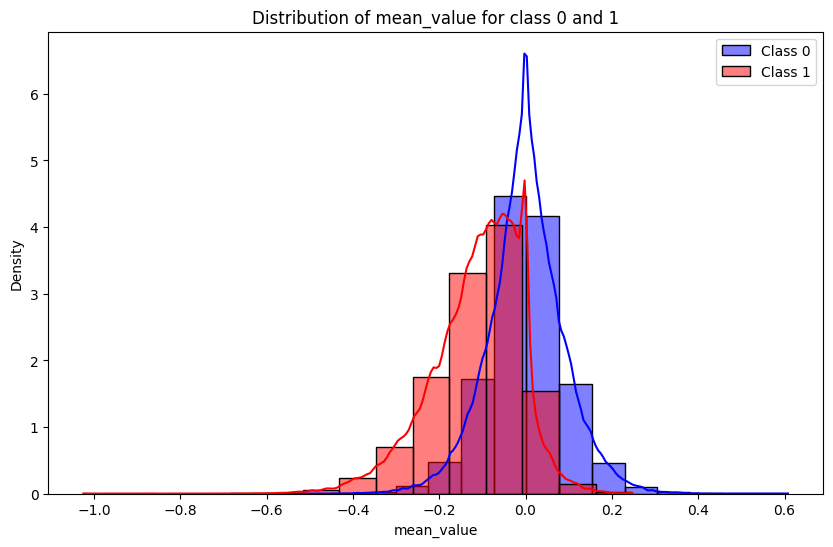

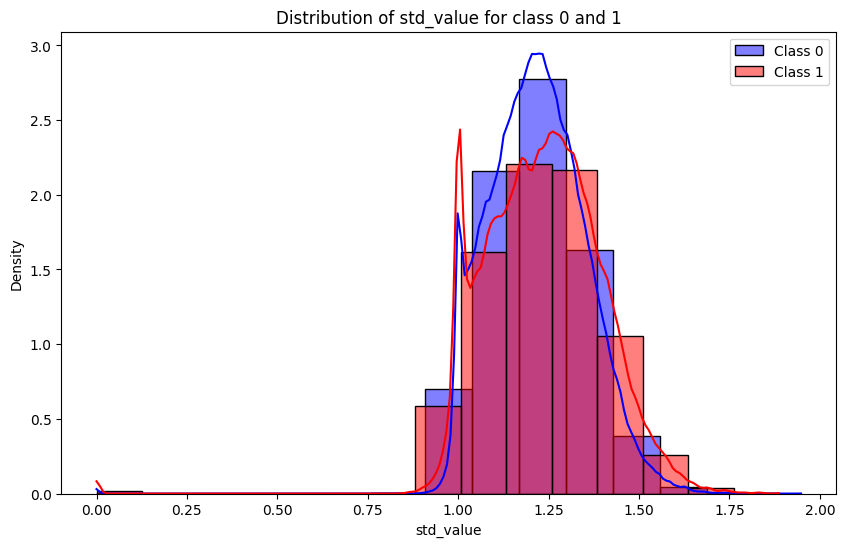

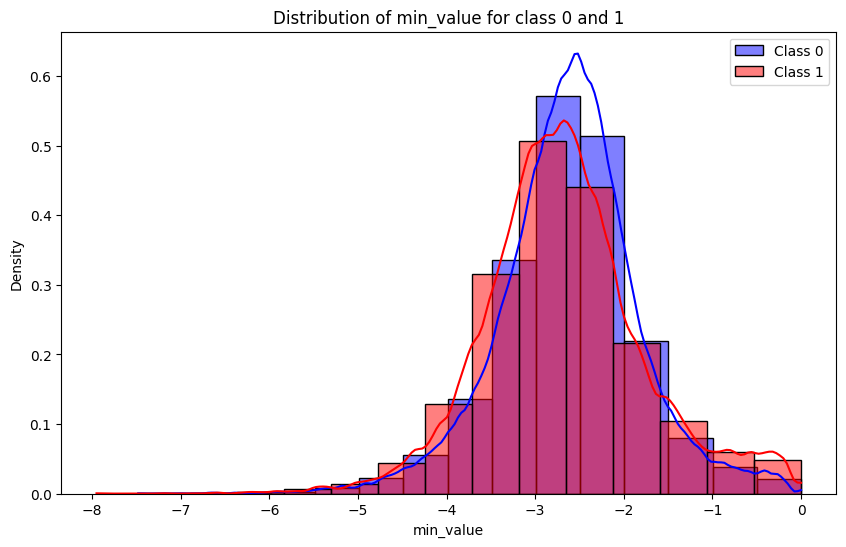

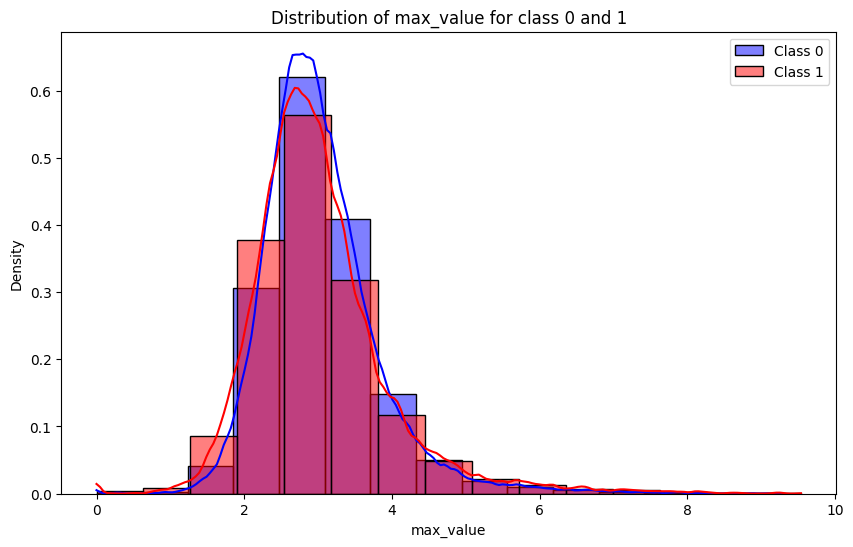

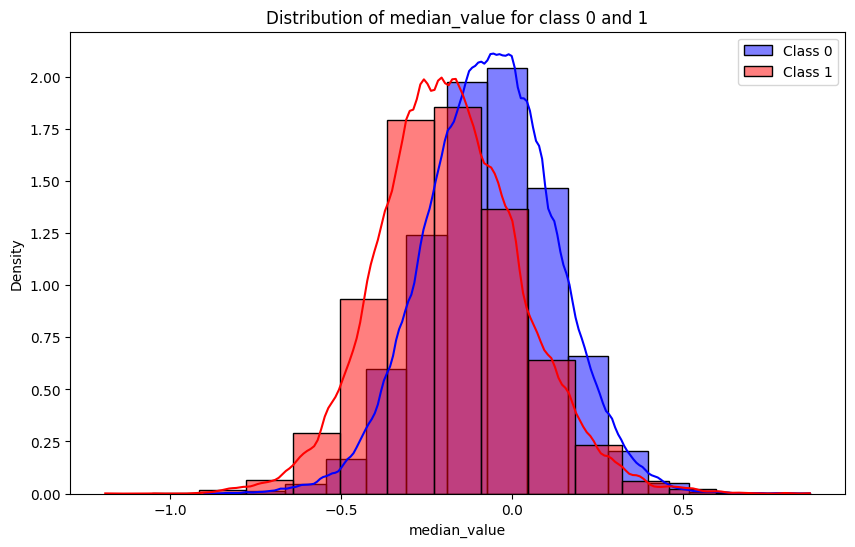

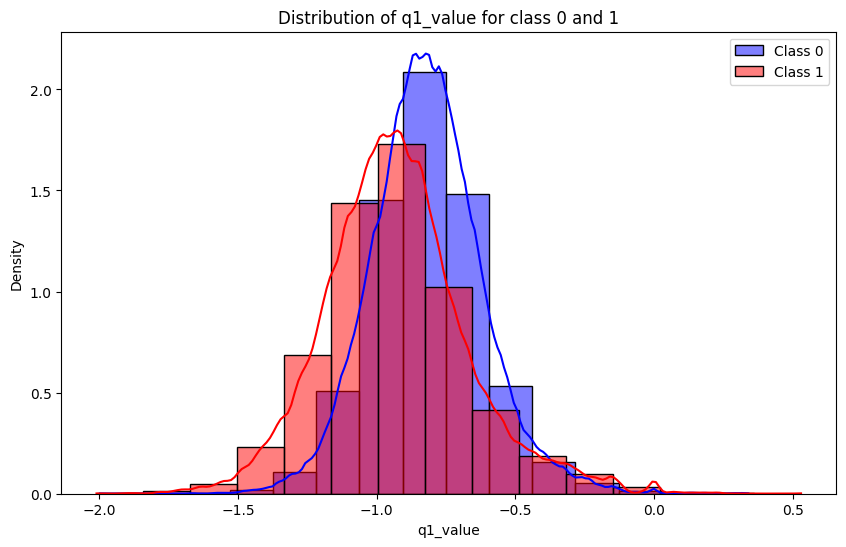

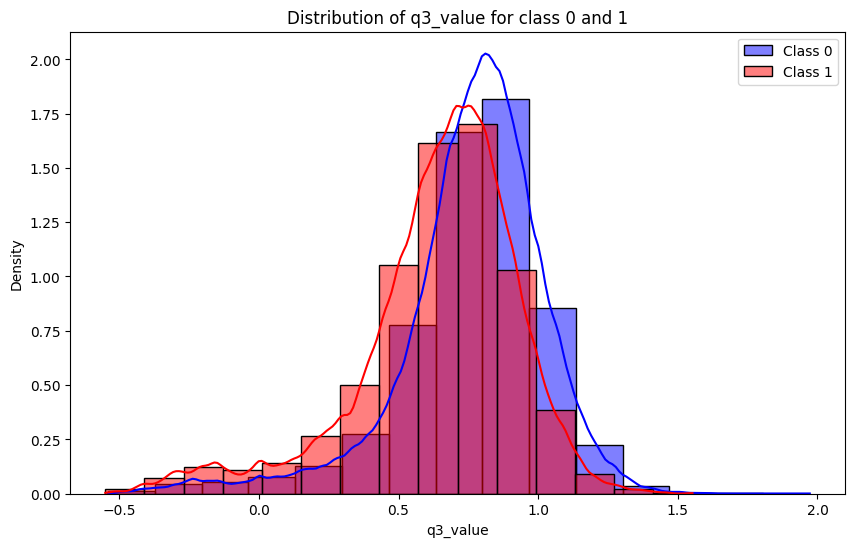

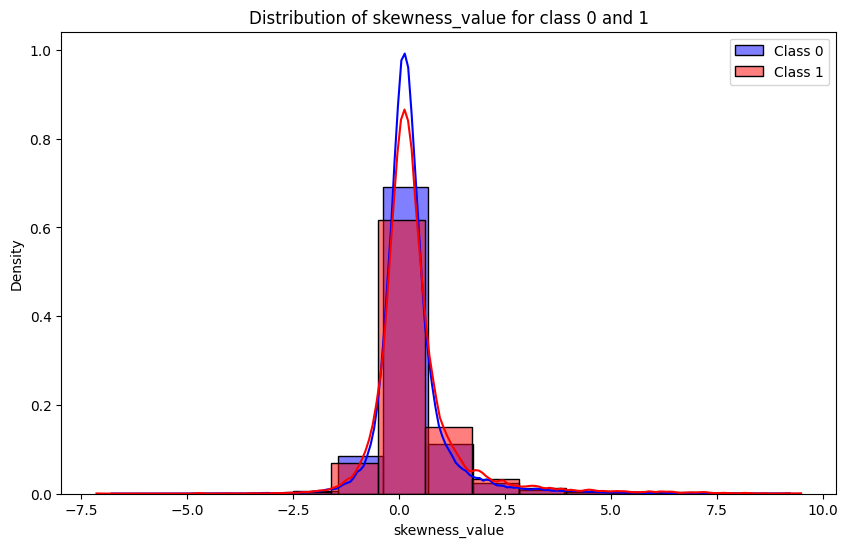

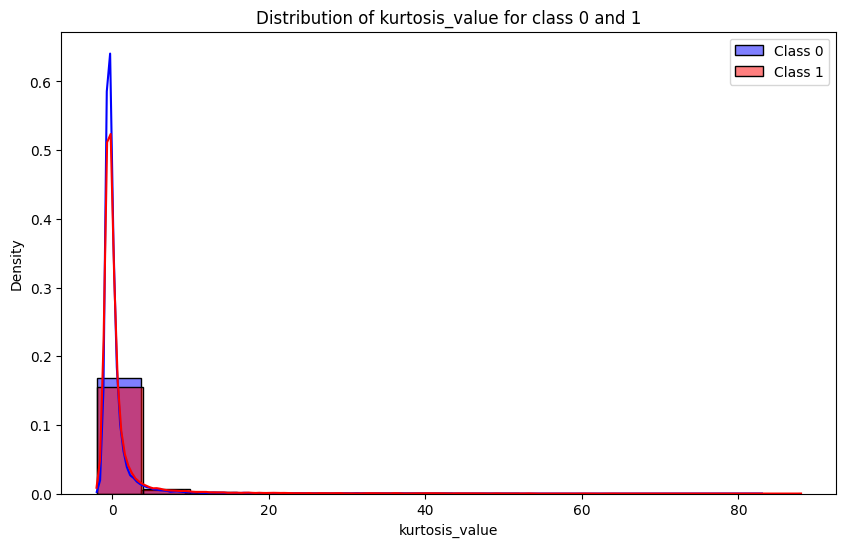

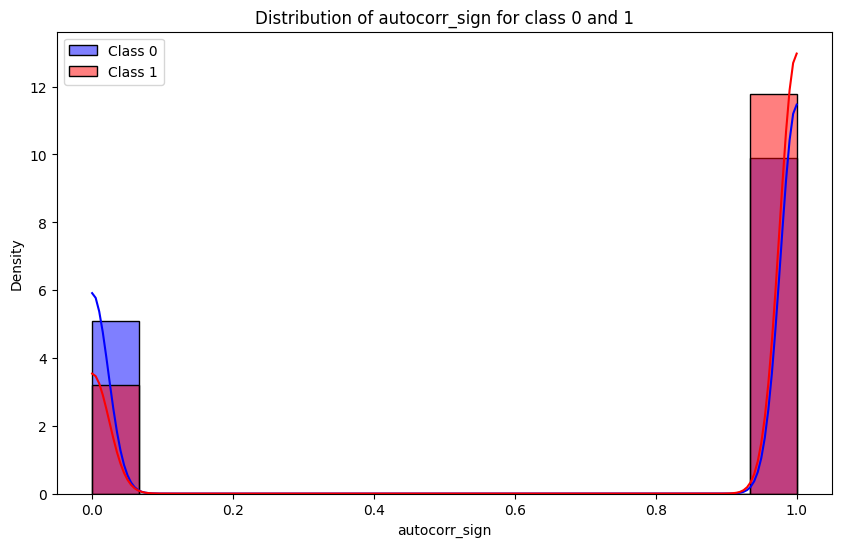

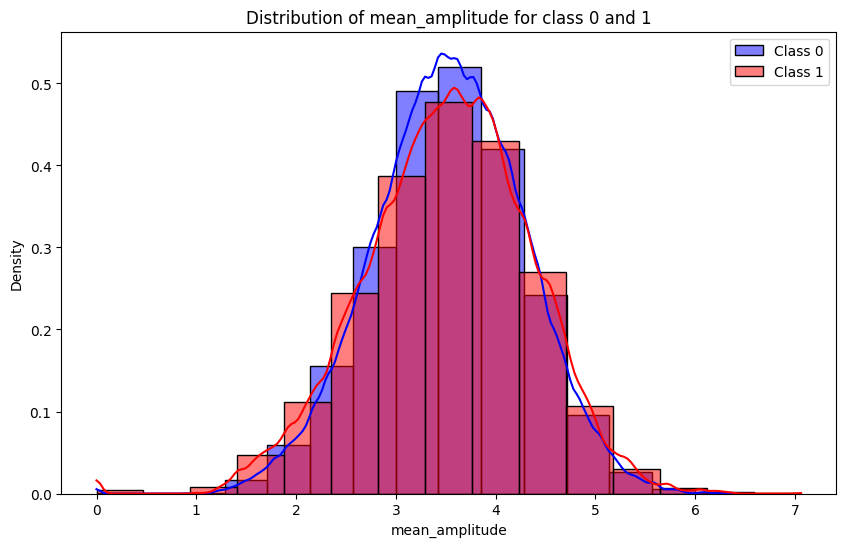

In [36]:
class_0 = train_stat_corr_ampl[train_stat_corr_ampl['label'] == 0.0]
class_1 = train_stat_corr_ampl[train_stat_corr_ampl['label'] == 1.0]

for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(class_0[feature], color='blue', label='Class 0', kde=True, stat='density', bins=15)
    sns.histplot(class_1[feature], color='red', label='Class 1', kde=True, stat='density', bins=15)
    plt.title(f"Distribution of {feature} for class 0 and 1")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

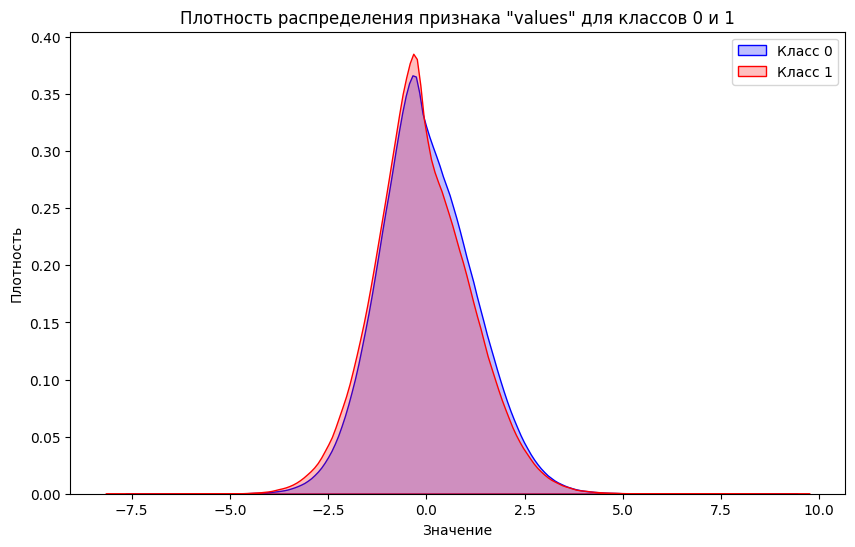

In [37]:
plt.figure(figsize=(10, 6))
sns.kdeplot(train_stat_corr_ampl[train_stat_corr_ampl['label'] == 0.0]['values'], color='blue', label='Класс 0', fill=True)
sns.kdeplot(train_stat_corr_ampl[train_stat_corr_ampl['label'] == 1.0]['values'], color='red', label='Класс 1', fill=True)
plt.title('Плотность распределения признака "values" для классов 0 и 1')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.legend()
plt.show()


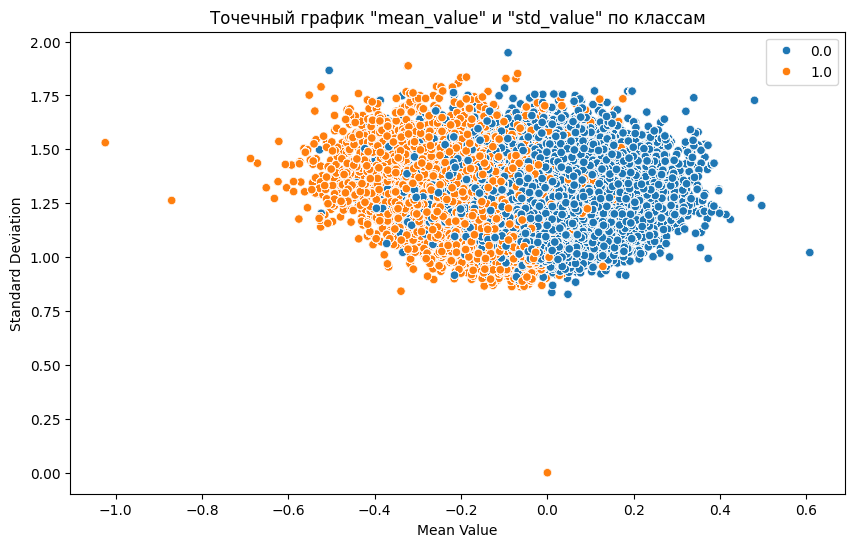

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_value', y='std_value', hue='label', data=train_stat_corr_ampl)
plt.title('Точечный график "mean_value" и "std_value" по классам')
plt.xlabel('Mean Value')
plt.ylabel('Standard Deviation')
plt.legend(loc='upper right')
plt.show()

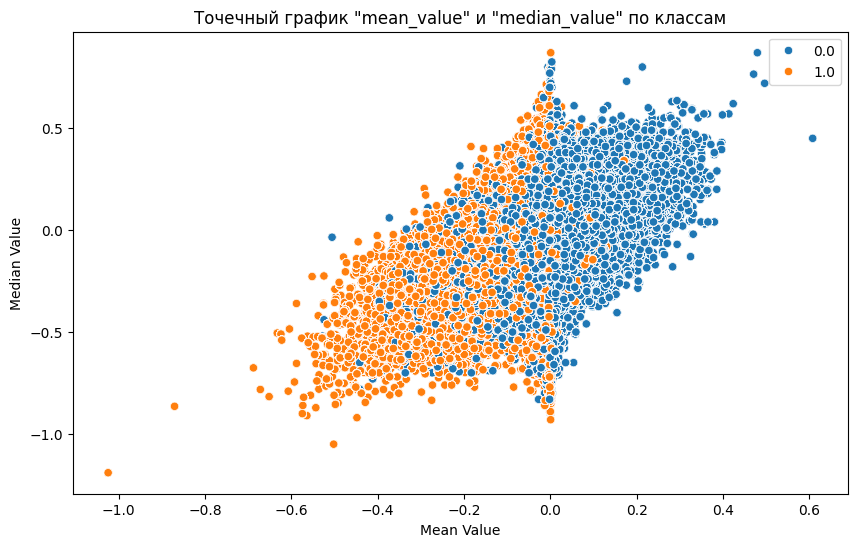

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_value', y='median_value', hue='label', data=train_stat_corr_ampl)
plt.title('Точечный график "mean_value" и "median_value" по классам')
plt.xlabel('Mean Value')
plt.ylabel('Median Value')
plt.legend(loc='upper right')
plt.show()

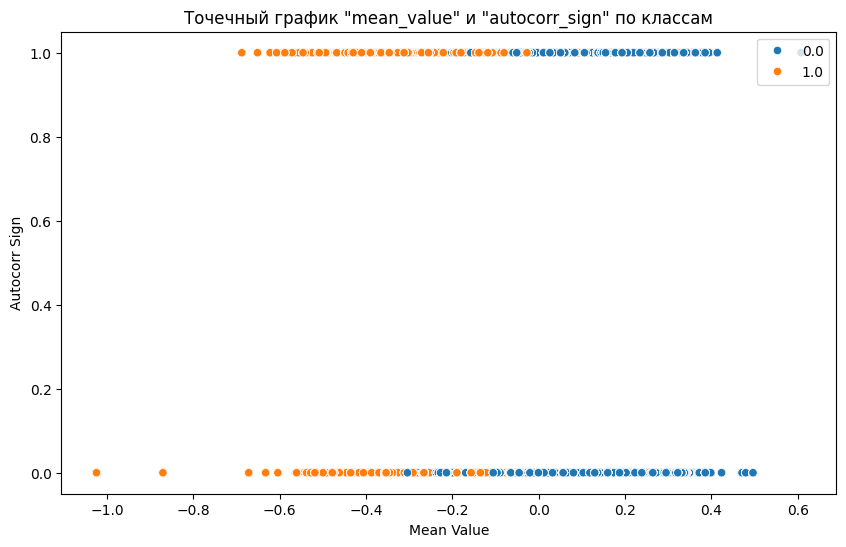

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_value', y='autocorr_sign', hue='label', data=train_stat_corr_ampl)
plt.title('Точечный график "mean_value" и "autocorr_sign" по классам')
plt.xlabel('Mean Value')
plt.ylabel('Autocorr Sign')
plt.legend(loc='upper right')
plt.show()

In [41]:
train_stat_corr_ampl.head()

id      dates  values  label  mean_value  std_value  min_value  \
id                                                                     
0  0   0 2016-01-01    1.74    0.0    -0.02403   1.040184      -1.63   
   1   0 2016-02-01    2.97    0.0    -0.02403   1.040184      -1.63   
   2   0 2016-03-01    0.44    0.0    -0.02403   1.040184      -1.63   
   3   0 2016-04-01    1.06    0.0    -0.02403   1.040184      -1.63   
   4   0 2016-05-01   -1.13    0.0    -0.02403   1.040184      -1.63   

      max_value  median_value  q1_value  q3_value  skewness_value  \
id                                                                  
0  0       5.57         -0.16     -0.54     0.145         2.78977   
   1       5.57         -0.16     -0.54     0.145         2.78977   
   2       5.57         -0.16     -0.54     0.145         2.78977   
   3       5.57         -0.16     -0.54     0.145         2.78977   
   4       5.57         -0.16     -0.54     0.145         2.78977   

      kurtosis_value  autocorr_sign  mean_amplitude  
id                                                   
0  0       11.574777              0        3.235294  
   1       11.574777              0        3.235294  
   2       11.574777              0        3.235294  
   3       11.574777              0        3.235294  
   4       11.574777              0        3.235294

### Correlation matrix

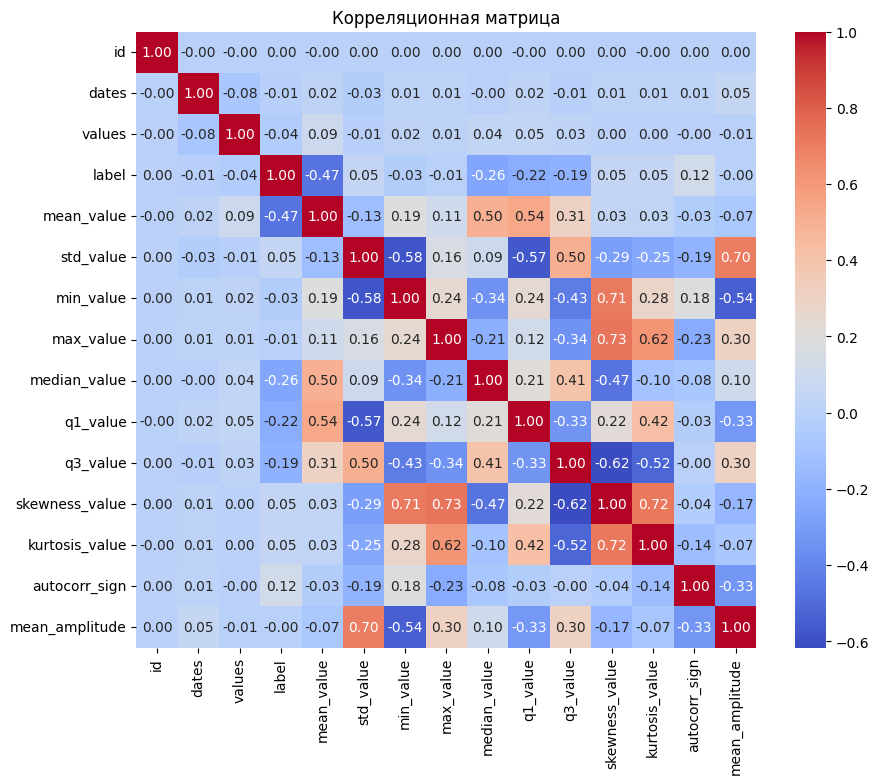

In [42]:
correlation_matrix = train_stat_corr_ampl.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [43]:
train_df = train_stat_corr_ampl.drop(['dates', 'values'], axis=1)

##### Delete features with hight correlation

In [44]:
threshold = 0.6

high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_pairs.add((colname, correlation_matrix.columns[j]))

print("features with hight correlation:")
for pair in high_corr_pairs:
    print(pair)

features with hight correlation:
('kurtosis_value', 'skewness_value')
('kurtosis_value', 'max_value')
('mean_amplitude', 'std_value')
('skewness_value', 'max_value')
('skewness_value', 'q3_value')
('skewness_value', 'min_value')


In [45]:
to_remove = set()

for pair in high_corr_pairs:
    to_remove.add(pair[1])

reduced_data = train_df.drop(columns=to_remove)
print("Other features:")
print(reduced_data)

Other features:
                  id  label  mean_value  median_value  q1_value  \
id                                                                
0     0            0    0.0   -0.024030         -0.16 -0.540000   
      1            0    0.0   -0.024030         -0.16 -0.540000   
      2            0    0.0   -0.024030         -0.16 -0.540000   
      3            0    0.0   -0.024030         -0.16 -0.540000   
      4            0    0.0   -0.024030         -0.16 -0.540000   
...              ...    ...         ...           ...       ...   
99999 5155407  99999    1.0   -0.179921         -0.33 -1.295242   
      5155408  99999    1.0   -0.179921         -0.33 -1.295242   
      5155409  99999    1.0   -0.179921         -0.33 -1.295242   
      5155410  99999    1.0   -0.179921         -0.33 -1.295242   
      5155411  99999    1.0   -0.179921         -0.33 -1.295242   

               kurtosis_value  autocorr_sign  mean_amplitude  
id                                               

In [46]:
percentage_ratio(reduced_data)

,Data Type,Missing Values,% Missing Values
id,int64,0,0.0
label,float64,0,0.0
mean_value,float64,0,0.0
median_value,float64,0,0.0
q1_value,float64,0,0.0
kurtosis_value,float64,0,0.0
autocorr_sign,int64,0,0.0
mean_amplitude,float64,0,0.0


In [47]:
print(f'The size of the data before deleting duplicates: {reduced_data.shape}')
reduced_data = reduced_data.drop_duplicates()
print(f'The size of the data after deleting duplicates: {reduced_data.shape}')

The size of the data before deleting duplicates: (5155412, 8)
The size of the data after deleting duplicates: (80000, 8)


### Train model

In [56]:
X = reduced_data.drop('label', axis=1)
y = reduced_data['label']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data_df = pd.DataFrame(scaled_data, columns=X.columns)

X_train, X_val, y_train, y_val = split(scaled_data_df, y, test_size=0.3)

##### Undersamplig

In [49]:
undersample = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

In [60]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svc',SVC(probability=True, random_state=42)),
    ('dtree',DecisionTreeClassifier()),
    ('knn',KNeighborsClassifier(n_neighbors=2)),
    ('Naive',GaussianNB())
]

clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression())

In [61]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf.fit(X_resampled, y_resampled)

val_score = clf.score(X_val, y_val)
print(f"Validation Accuracy: {val_score:.4f}")

y_val_pred_prob = clf.predict_proba(X_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC on Validation set: {roc_auc_val:.4f}")

Validation Accuracy: 0.7730
ROC AUC on Validation set: 0.8768


In [58]:
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# y_pred_proba = cross_val_predict(clf, X_resampled, y_resampled, cv=cv, method='predict_proba')

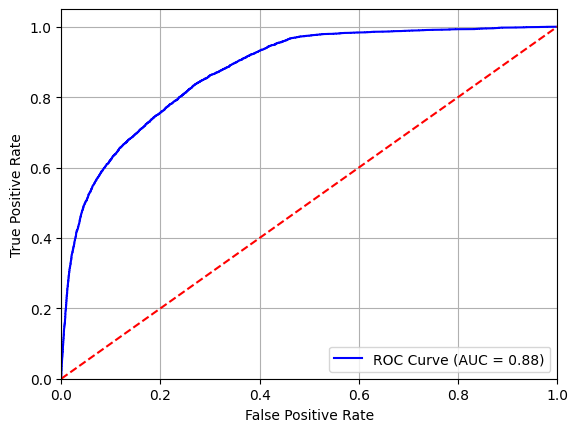

In [62]:
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
plt.plot(fpr, tpr, color="blue", label=f'ROC Curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Tuning

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svc',SVC(kernel='rbf', probability=True, random_state=42)),
    ('dtree',DecisionTreeClassifier()),
    ('knn',KNeighborsClassifier(n_neighbors=2)),
    ('Naive',GaussianNB())]

clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression())

param_grid = {
    'rf__n_estimators': [10, 50, 100],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto'],
    'knn__n_neighbors': [1, 3, 5],
    'final_estimator__C': [0.1, 1, 10],}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [ ]:
y_val_pred_prob = grid_search.predict_proba(X_val)[:, 1]

In [ ]:
train_scores = grid_search.cv_results_['mean_train_score']
val_scores = grid_search.cv_results_['mean_test_score']
param_range = range(len(train_scores))

plt.plot(param_range, train_scores, label='Train ROC AUC', marker='o')
plt.plot(param_range, val_scores, label='Validation ROC AUC', marker='o')
plt.title('Train vs Validation ROC AUC')
plt.xlabel('Parameter combination index')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf.fit(X_resampled, y_resampled)

val_score = clf.score(X_val, y_val)
print(f"Validation Accuracy: {val_score:.4f}")

y_val_pred_prob = clf.predict_proba(X_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_val_pred_prob)
print(f"ROC AUC on Validation set: {roc_auc_val:.4f}")

Validation Accuracy: 0.7731
ROC AUC on Validation set: 0.8766
